## Bayesian AB Testing
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Running on PyMC3 v3.5


### コイン投げの確率分布

In [2]:
# 事前分布の設定
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [3]:
# 真の値
p_true = 0.05  # 本来は不明
N = 1500

# ベルヌーイ分布： Ber(0.05)
occurrences = stats.bernoulli.rvs(p_true, size=N)

#  Python treats True == 1, and False == 0
print(occurrences) 
print(np.sum(occurrences))

[0 0 0 ... 0 1 0]
79


In [4]:
#  サンプリングした集団は真の確率とは一致していない
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0527
Does this equal the true frequency? False


In [5]:
#  ベルヌーイ分布からサンプリング
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    
    # メトロポリス法
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]
Sampling 2 chains: 100%|██████████| 37000/37000 [00:04<00:00, 7796.66draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


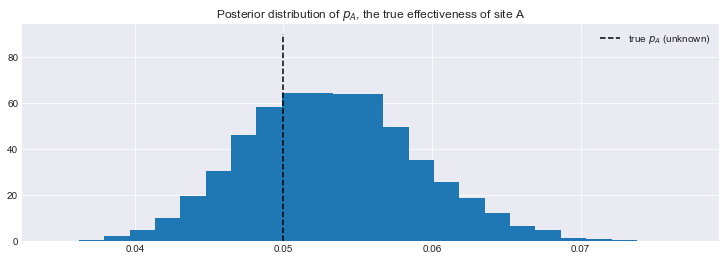

In [6]:
# 真の分布とは異なる
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend()
plt.show()

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]
Sampling 2 chains: 100%|██████████| 37000/37000 [00:05<00:00, 6561.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


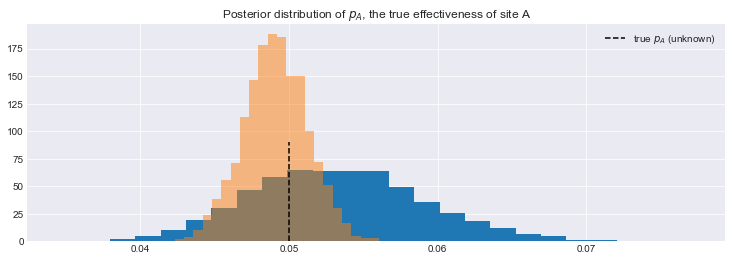

In [7]:
# よりサンプリングの数を増やしてみる
p_true = 0.05 
N = 10000 # 1500 -> 10000
occurrences = stats.bernoulli.rvs(p_true, size=N)

with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace2 = trace[1000:]
    
# 真の分布とは異なるが、Nを増やすことで真の分布に近づく
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.hist(burned_trace2["p"], bins=25, histtype="stepfilled", normed=True, alpha=0.5)
plt.legend()
plt.show()

### A, Bの群を分けることができるか

In [8]:
# 真の値は実際は不明
true_p_A = 0.05
true_p_B = 0.04

# サンプル数
N_A = 1500
N_B = 750

#　ベルヌーイ分布からサンプリング
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] ...


In [9]:
# 平均での比較
print(np.mean(observations_A))
print(np.mean(observations_B))

0.04066666666666666
0.03333333333333333


In [10]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    # 差の分布の推定
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:] # 最初の部分は捨てる

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:08<00:00, 4748.98draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [11]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


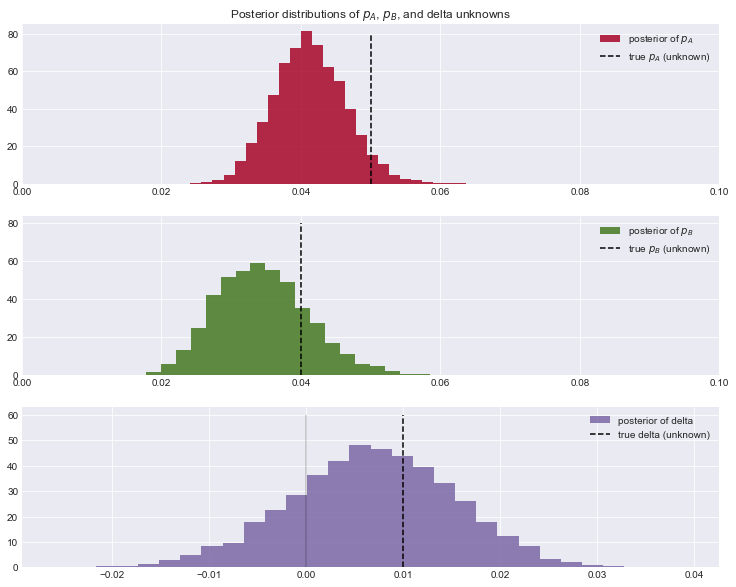

In [12]:
plt.figure(figsize=(12.5, 10))

#  ヒストグラム
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [13]:
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.210
Probability site A is BETTER than site B: 0.790


### to function

ベータ分布B(1,1)は一様分布U(0,1)に等しい  
事前分布でN回投げてX回成功していたとするとこの時の事後分布は  
B(1+X, 1+(N-X))
に従う

## CVなどの0-1ABテスト

In [76]:
def BayesABtesting(observations_A, observations_B):

    # Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
    with pm.Model() as model:
        p_A = pm.Uniform("p_A", 0, 1)
        p_B = pm.Uniform("p_B", 0, 1)

        # Define the deterministic delta function. This is our unknown of interest.
        # 差の分布の推定
        delta = pm.Deterministic("delta", p_A - p_B)


        # Set of observations, in this case we have two observation datasets.
        obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
        obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

        step = pm.Metropolis()
        trace = pm.sample(20000, step=step)
        burned_trace=trace[1000:] # 最初の部分は捨てる

    p_A_samples = burned_trace["p_A"]
    p_B_samples = burned_trace["p_B"]
    delta_samples = burned_trace["delta"]

    plt.figure(figsize=(12.5, 10))

    #  ヒストグラム
    ax = plt.subplot(211)

    plt.xlim(0, .1)
    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_A$", color="#A60628", normed=True)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_B$", color="#467821", normed=True)
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

    ax = plt.subplot(212)
    plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
             label="posterior of delta", color="#7A68A6", normed=True)
    plt.vlines(0, 0, 60, color="black", alpha=0.2)
    plt.legend(loc="upper right");
    plt.show()
    
    print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

    print("Probability site A is BETTER than site B: %.3f" % \
        np.mean(delta_samples > 0))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:13<00:00, 3147.83draws/s]
The number of effective samples is smaller than 10% for some parameters.
/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


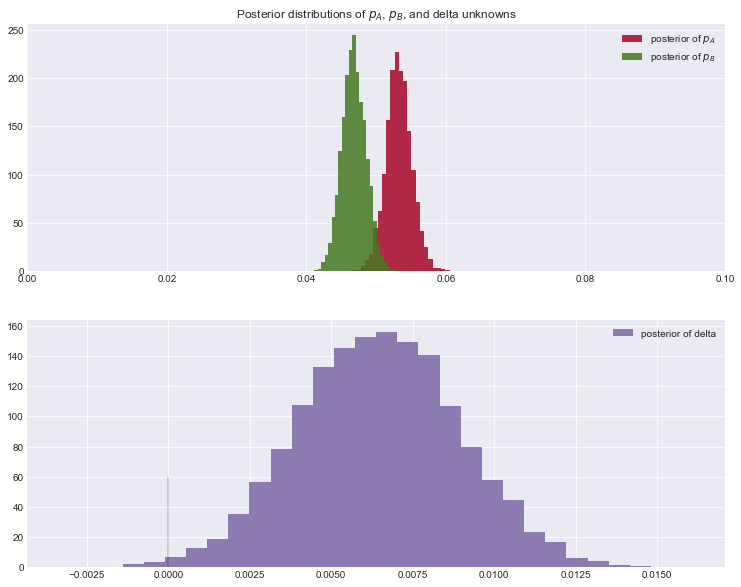

Probability site A is WORSE than site B: 0.005
Probability site A is BETTER than site B: 0.995


In [55]:
# 真の値は実際は不明
true_p_A = 0.050
true_p_B = 0.047

# サンプル数
N_A = 15000
N_B = 15000

#　ベルヌーイ分布からサンプリング
np.random.seed(40)
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)

BayesABtesting(observations_A, observations_B)

## 滞在時間などのポアソン分布で比較する

In [77]:
def BayesABtestingPoisson(observations_A, observations_B):

    # Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
    with pm.Model() as model:
        p_A = pm.Uniform("p_A", 0, 10e5)
        p_B = pm.Uniform("p_B", 0, 10e5)

        # Define the deterministic delta function. This is our unknown of interest.
        # 差の分布の推定
        delta = pm.Deterministic("delta", p_A - p_B)


        # Set of observations, in this case we have two observation datasets.
        obs_A = pm.Poisson("obs_A", p_A, observed=observations_A)
        obs_B = pm.Poisson("obs_B", p_B, observed=observations_B)

        step = pm.Metropolis()
        trace = pm.sample(20000, step=step)
        burned_trace=trace[1000:] # 最初の部分は捨てる

    p_A_samples = burned_trace["p_A"]
    p_B_samples = burned_trace["p_B"]
    delta_samples = burned_trace["delta"]

    plt.figure(figsize=(12.5, 10))

    #  ヒストグラム
    ax = plt.subplot(211)

    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_A$", color="#A60628", normed=True)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_B$", color="#467821", normed=True)
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

    ax = plt.subplot(212)
    plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
             label="posterior of delta", color="#7A68A6", normed=True)
    plt.vlines(0, 0, 60, color="black", alpha=0.2)
    plt.legend(loc="upper right");
    plt.show()
    
    print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

    print("Probability site A is BETTER than site B: %.3f" % \
        np.mean(delta_samples > 0))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:07<00:00, 5419.35draws/s]
The number of effective samples is smaller than 10% for some parameters.
/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


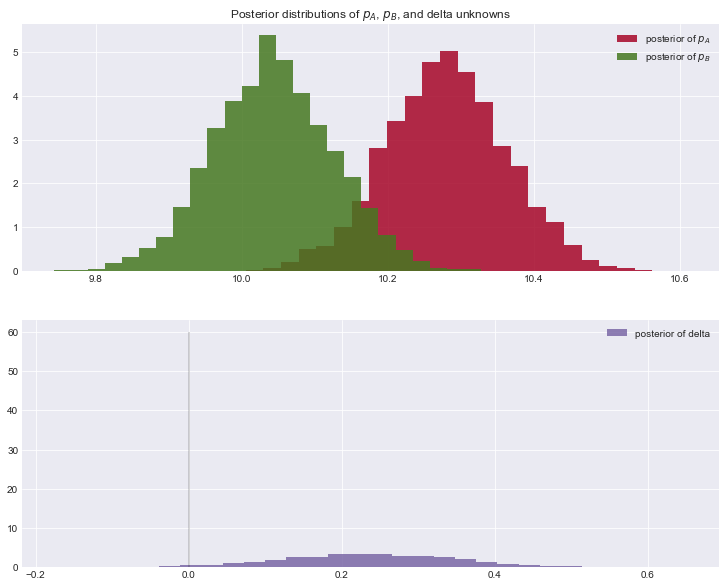

Probability site A is WORSE than site B: 0.022
Probability site A is BETTER than site B: 0.978


In [84]:
# 真の値は実際は不明
true_A = 10.2
true_B = 10

# サンプル数
N_A = 1500
N_B = 1500

#　ベルヌーイ分布からサンプリング
np.random.seed(40)
observations_A = stats.poisson.rvs(true_A, size=N_A)
observations_B = stats.poisson.rvs(true_B, size=N_B)

BayesABtestingPoisson(observations_A, observations_B)